In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft, ifft, fftfreq, irfft
import scipy.signal as sig
from scipy.io import wavfile
from scipy.stats import ttest_ind
from playsound import playsound
%matplotlib inline

In [2]:
def gather_data(samplerate,data):
    N = data.shape[0]
    length = N / samplerate
    T0 = length
    dt = T0/N
    time = np.linspace(0., length, data.shape[0])

    return N, length, T0, dt, time   

def cleaning(samplerate,data,freqCutoff):
    
    N, length, T0, dt, time = gather_data(samplerate, data)

    Vdusty = (2/N)*fft(data[:, 1])
    freq = fftfreq(N,dt)
    
    VCleanf = Vdusty.copy()

    for i in range(len(freq)):
        if abs(freq[i]) > freqCutoff:
            VCleanf[i] = 0       

    VClean = ifft(N*VCleanf)
    VC = np.real(VClean)
    return time,VClean,freq

In [3]:
ps_sr, ps_dat = wavfile.read('./peace-sells-intro.wav')

hw_sr, hw_dat = wavfile.read('./holy-wars-intro.wav')

cat_sr, cat_dat = wavfile.read('./greatest-song-ever-intro.wav')

C:\Users\elias\AppData\Local\Temp\ipykernel_20384\3418896276.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  ps_sr, ps_dat = wavfile.read('./peace-sells-intro.wav')
C:\Users\elias\AppData\Local\Temp\ipykernel_20384\3418896276.py:3: WavFileWarning: Reached EOF prematurely; finished at 16772276 bytes, expected 16772284 bytes from header.
  hw_sr, hw_dat = wavfile.read('./holy-wars-intro.wav')


In [4]:
ps_N, ps_length, ps_T0, ps_dt, ps_time = gather_data(ps_sr, ps_dat)

hw_N, hw_length, ps_T0, hw_dt, hw_time = gather_data(hw_sr, hw_dat)

cat_N, cat_length, cat_T0, cat_dt, cat_time = gather_data(hw_sr, hw_dat)

ps_cutoff = 100

hw_cutoff = 600

cat_cutoff = 500

ps_time, ps_intro, ps_freq = cleaning(ps_sr, ps_dat, ps_cutoff)

hw_time, hw_intro, hw_freq = cleaning(hw_sr, hw_dat, hw_cutoff)

cat_time, cat_intro, cat_freq = cleaning(cat_sr, cat_dat, cat_cutoff)

In [5]:
wavfile.write("./ps_cleaned.wav", ps_sr, np.abs(ps_intro))
wavfile.write("./hw_cleaned.wav", hw_sr, np.abs(hw_intro))

In [6]:
ps_cleaned_fft = (2/ps_N)*fft(ps_intro)


hw_cleaned_fft = (2/hw_N)*fft(hw_intro)


cat_cleaned_fft = (2/cat_N)*fft(cat_intro)


In [7]:
print(len(ps_freq))
print(len(ps_cleaned_fft))

663942
663942


(0.0, 150.0, 0.0, 400.0)

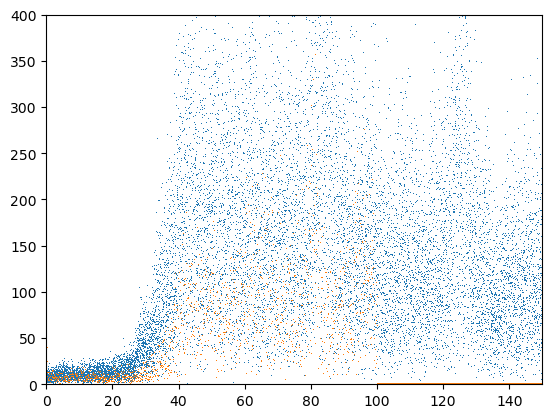

In [16]:
plt.plot(hw_freq[0:hw_N//2], np.abs(hw_cleaned_fft[0:hw_N//2]), marker = ",", linestyle="")

plt.plot(ps_freq[0:ps_N//2], np.abs(ps_cleaned_fft[0:ps_N//2]), marker = ",", linestyle="")

plt.axis([0,150,0,400])

Below, we find the differences between the amplitudes of the power series of the songs in our investigation for each frequency. Since we are only performing simple pairwise analysis, we found it best to simply take the normalized difference between the two songs in our analysis and then characterize the differences between the power series by plotting our findings.

Unfortunately, this process is not as straight forward as simply subtracting the two power series with one another. Since each of the power series we generated from our fourier transoformations of our songs are each binned in frequency bins of different sizes, a simple array operation is not possible. To actually perform this operation, we must perform a rebinning operation on one of the arrays such that the two arrays are of the same length and binsize. As such we must employ the use of the below *rebin_diff* function to take in the data of two different power series, then output the rebinned differences between the two series.

In [9]:
def rebin_diff(fft_1, fft_2, freq_1, freq_2):
    """
    Takes in 2 fft's and their respective frequencies, then outputs a rebinned
    array containing their sums and differences.
    
    args:
    
        fft_1 - signal array from an fft transofrmation. Should be the shorter
                of the two arrays
        fft_2 - similar to fft_1. Is the longer of the two signals
        
        freq_1 - frequency array associated with fft_1
        
        freq_2 - frequency array associated with fft_2
    
    returns:
        
        amp_diff - differences of the values contained in the two input fft's.
                   Array is same size as fft_1 array.
        
    """
    
    # initializing arrays
    amp_diff = np.zeros(len(freq_1))
    
    # assigning fft_1 values to array as initial values
    amp_diff = amp_diff + fft_1
    
    # for tracking index of fft_1, amp_diff and amp_sum arrays
    j = 0
    
    # loops through each index of the longer array
    for i in range(len(freq_2)):
    
        # checks to see if indexing is to close to upper bound
        # of fft_1 array
        if j < len(freq_1)-2:
            
            # if freq_2 bin is greater than current right bound
            # of freq_1 bin, increment j
            if freq_1[j+1] <= freq_2[i]:
                j += 1        
            
            # finding difference between freq_1 cells
            dist = freq_1[j+1] - freq_1[j]
            
            # finds absolute distance between freq_2 cell and freq_1 cell
            f_dist = np.abs(freq_2[i] - freq_1[j])
            norm_f_dist = f_dist/dist
            
            # adds data to amp_diff array
            amp_diff[j] -= fft_2[i]*(1-norm_f_dist)
            amp_diff[j+1] -= fft_2[i]*norm_f_dist

        else:
            # just tacks on remaining fft_2 to end of output arrays
            # not exacltly super accurate, but doesn't cause
            # significant problems
            amp_diff[j] -= fft_2[i]
            
    return amp_diff


In [74]:
# gener

ps_v_hw_diff = rebin_diff(ps_cleaned_fft, hw_cleaned_fft, ps_freq, hw_freq)

cat_v_ps_diff = rebin_diff(cat_cleaned_fft, ps_cleaned_fft, cat_freq, ps_freq)

hw_v_cat_diff = rebin_diff(hw_cleaned_fft, cat_cleaned_fft, hw_freq, cat_freq)

In [75]:
print(np.max(np.abs(ps_v_hw_diff)))

print(np.max(np.abs(cat_v_ps_diff)))

print(np.max(np.abs(hw_v_cat_diff)))

1169.0404401520213
3994590.799390734
659883.0694046603


In [34]:
ps_v_hw_norm_diff = np.abs(ps_v_hw_diff)/np.max(np.abs(ps_v_hw_diff))

cat_v_ps_norm_diff = np.abs(cat_v_ps_diff)/np.max(np.abs(cat_v_ps_diff))

hw_v_cat_norm_diff = np.abs(hw_v_cat_diff)/np.max(np.abs(hw_v_cat_diff))

remove_outlier_mask = np.where(hw_v_cat_norm_diff >= 0.5)
print(remove_outlier_mask)

hw_v_cat_norm_diff[remove_outlier_mask] = 0 

hw_v_cat_renorm_diff = hw_v_cat_norm_diff/np.max(np.abs(hw_v_cat_norm_diff))

(array([177274, 177275], dtype=int64),)


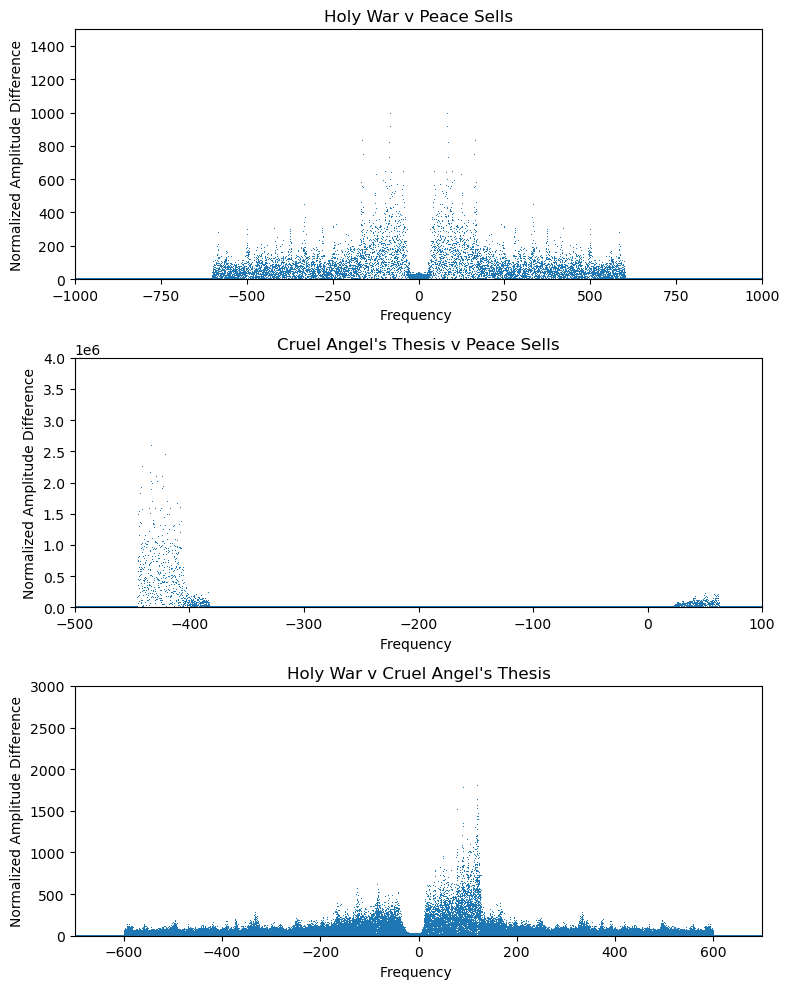

In [76]:
fig, ax = plt.subplots(3,1, figsize = (8,10))

ax[0].plot(ps_freq,ps_v_hw_diff, marker = ",", linestyle="")
ax[0].axis([-1000,1000,0,1500])
ax[0].set_xlabel("Frequency ")
ax[0].set_ylabel("Normalized Amplitude Difference")
ax[0].set_title("Holy War v Peace Sells")


ax[1].plot(cat_freq, cat_v_ps_diff, marker = ",", linestyle="")
ax[1].axis([-500,100,0,4000000])
ax[1].set_xlabel("Frequency ")
ax[1].set_ylabel("Normalized Amplitude Difference")
ax[1].set_title("Cruel Angel's Thesis v Peace Sells")

ax[2].plot(hw_freq, hw_v_cat_diff, marker = ",", linestyle="")
ax[2].axis([-700,700,0,3000])
ax[2].set_xlabel("Frequency ")
ax[2].set_ylabel("Normalized Amplitude Difference")
ax[2].set_title("Holy War v Cruel Angel's Thesis")

plt.tight_layout()

Above we see the resulting plots of our power series comparisons. In the y-axis, we have the normalized difference in amplitude

In the first plot, Holy War v Peace Sells, we see